## PaleoSTeHM: A modern, scalable Spatio-Temporal Hierarchical Modeling framework for paleo-environmental data

Yucheng Lin - yc.lin@rutgers.edu

with Alex Reedy and Robert Kopp

## Tutorial 7: Temporal Gaussian Process modelling for New Jersey and Northern North Carolina (5-10 minutes)

In this tutorial, we will use what we've learnt so far to perform temporal Gaussian Process (GP) analysis with publishable qulity. To ensure this, we will compare our results here with GP modelling results from [Ashe et al., 2019](https://www.sciencedirect.com/science/article/abs/pii/S0277379118302130?casa_token=ehTQJ0z-n5UAAAAA:ZsNEE-ycwb8MiHR9pUTq2tjBoT-DjLeyPom7ANILl_euiU1xgyk093UZ7ZYwDc8MWrgMedgh8g#appsec2) who use the noisy-input Gaussian Process in the same dataset we will use in this tutorial. 

**&#10148; 1.** New Jersey

**&#10148; 2.** Northern North Carolina 

**&#10148; 3.** Try your own data!

### 1. New Jersey 

Let's start with New Jersey Holocene sea-level data from [Kemp et al., 2013](https://www.sciencedirect.com/science/article/abs/pii/S0277379113003740), which contains 135 sea-level data point each with: relative sea level, age, relative sea level uncertainty and age uncertainty. You should be familiar with this as we've used this dataset for the last few tutorials.


In [1]:
#load modules
import matplotlib.pyplot as plt
import matplotlib
import torch
import numpy as np
import pandas as pd
import pyro
import pyro.distributions as dist
import sys
sys.path.append('../../')
import PSTHM 
import time
from scipy import interpolate
pyro.set_rng_seed(0) #set random seed used in this notebook

#set plotting style
%matplotlib inline
font = {'weight':'normal',
       'size':20,
       'family':'Helvetica'}
matplotlib.rcParams['xtick.major.size'] = 8
matplotlib.rcParams['ytick.major.size'] = 8
matplotlib.rcParams['axes.labelsize'] = 22
matplotlib.rcParams['figure.figsize'] = (12, 6)
matplotlib.rcParams['legend.frameon'] = 'False'

matplotlib.rc('font',**font)
import warnings
warnings.filterwarnings("ignore")

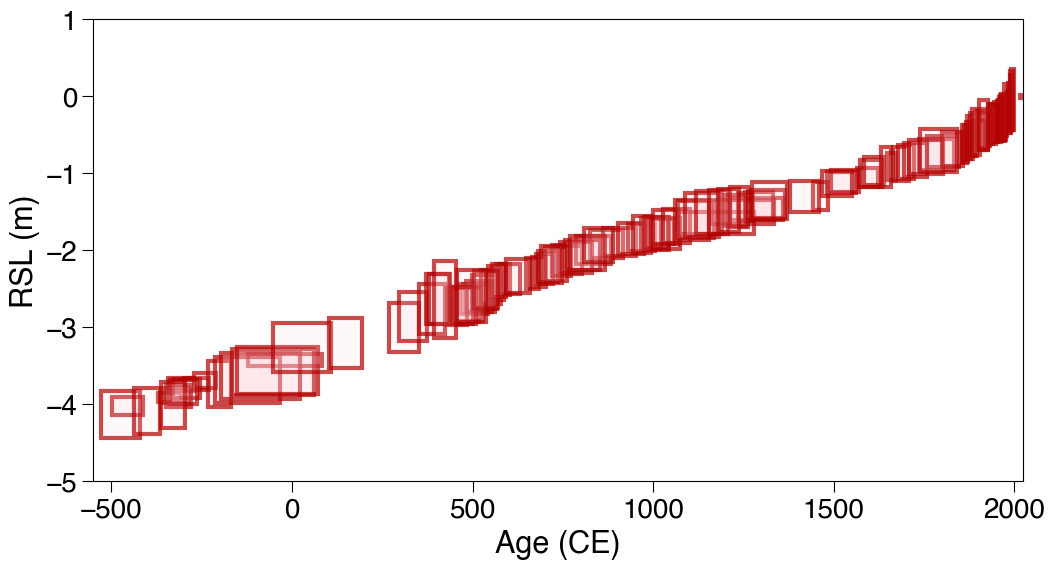

In [2]:
#load data 
X,y,y_sigma,x_sigma,lon,lat = PSTHM.load.load_local_rsl_data('../../Data/NJ_CC.csv')

#visualize data
ax = PSTHM.plotting.plot_uncertainty_boxes(X,y, x_sigma*2,y_sigma*2,CE=True)
ax.set_xlim(-550,2025)
ax.set_ylim(-5,1)
plt.show();

And here's the regression results from Ashe et al., 2019 obtained from [Erica's github](https://github.com/ericaashe/AsheEtAl2018). You can also find those results in Figure 3 in their [original paper](https://www.sciencedirect.com/science/article/abs/pii/S0277379118302130?casa_token=ehTQJ0z-n5UAAAAA:ZsNEE-ycwb8MiHR9pUTq2tjBoT-DjLeyPom7ANILl_euiU1xgyk093UZ7ZYwDc8MWrgMedgh8g#appsec2).

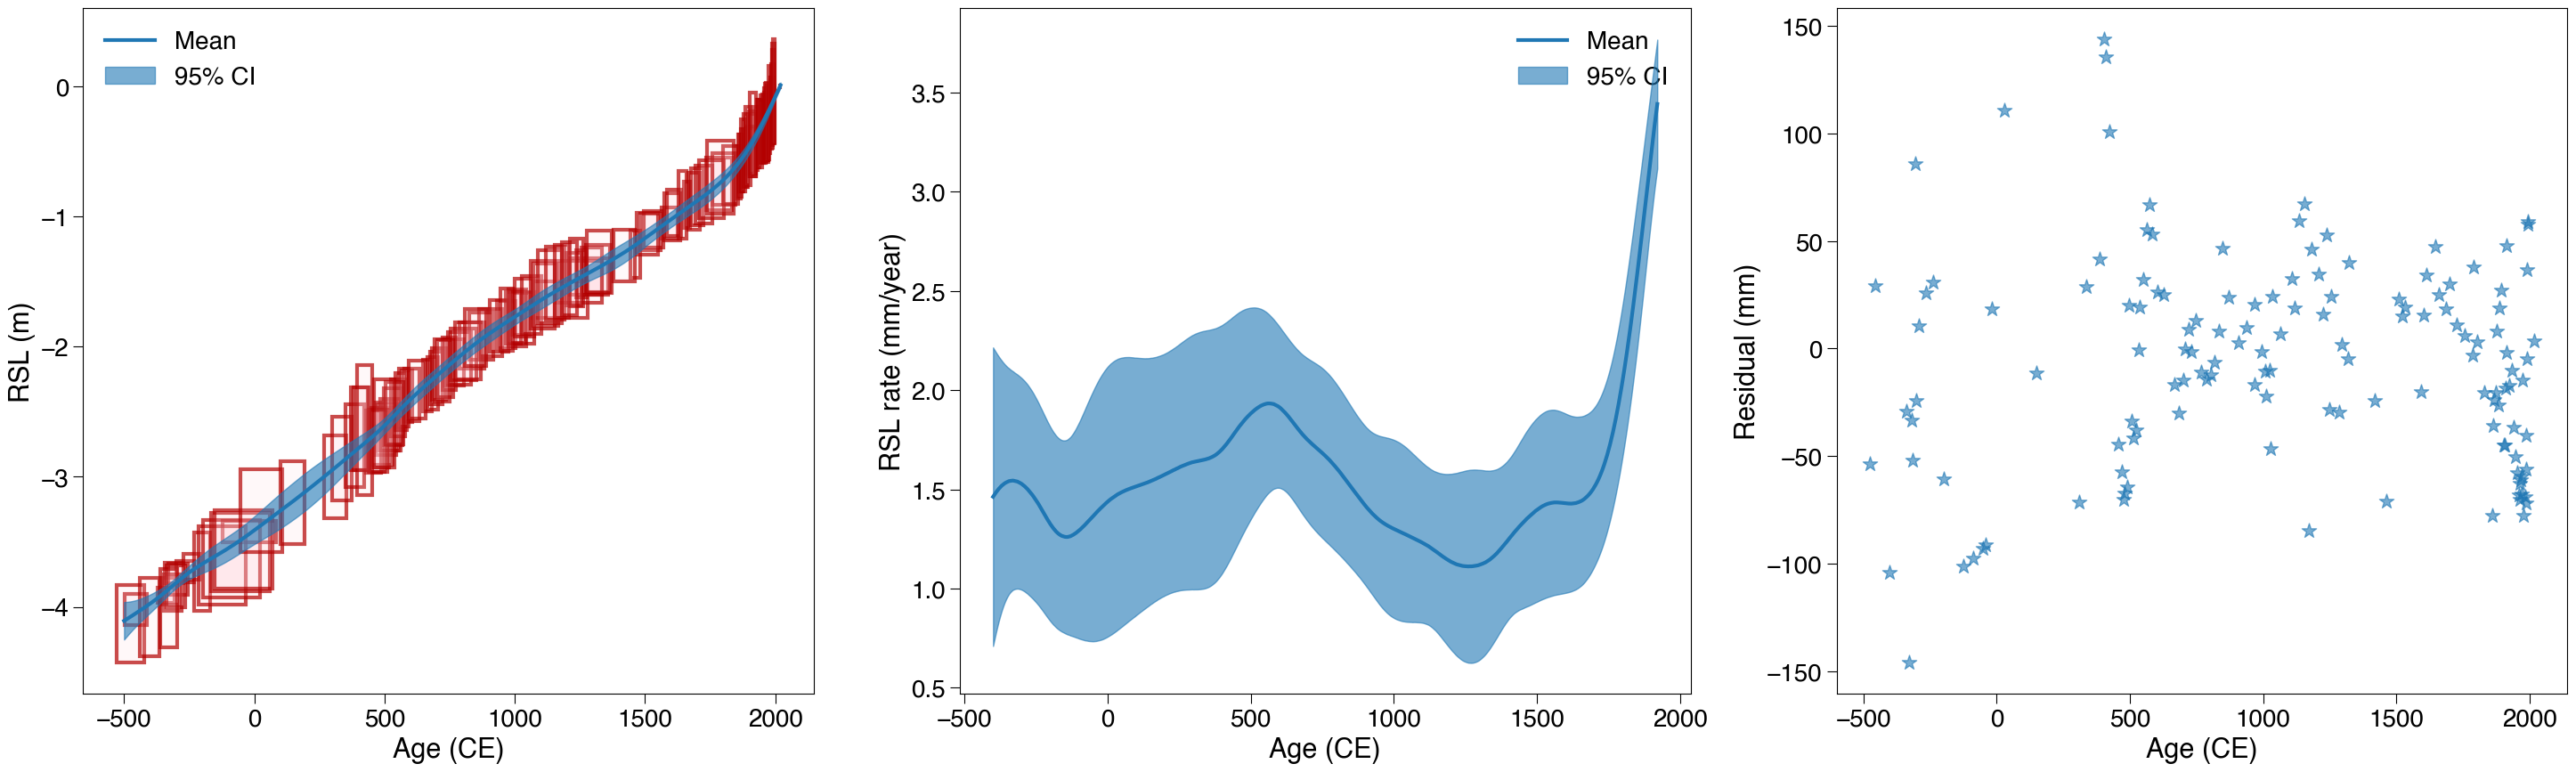

In [3]:
ashe_rsl_time = np.arange(-500,2025,5.)
ashe_mean_rsl = np.loadtxt('../../Data/ashe_mean.txt')/1000 #convert mm to m
cov_matrix = np.array(pd.read_csv('../../Data/ashe_cov.csv',header=None)) 
ashe_sd = np.sqrt(np.diag(cov_matrix))/1000
rsl_rate_time,ashe_rsl_rate,ashe_rsl_rate_sd = PSTHM.post.cal_rate_var(ashe_rsl_time,cov_matrix,ashe_mean_rsl)
ashe_rsl_rate_sd/=1000 #convert mm to m

#--------plotting---------
axes = PSTHM.plotting.plot_tem_regression(X,y,x_sigma,y_sigma,ashe_rsl_time,ashe_mean_rsl,ashe_sd,
                          rsl_rate_time,ashe_rsl_rate,ashe_rsl_rate_sd)

Let's use our noisy-input GP model for this data. But differ to tutorial 5, this time, we are using three kernels for this problem, the same as used in Ashe et al., 2019. Specifically, we will use a 3/2 Matérn kernel with large variance and length scale hyperparameters to represent global sea-level change trend along with a 3/2 Matérn kernel with medium variance and length scale to indicate regional sea-level variance. We can differentiate them from each other by setting prior distributions for hyperparameters to different ranges. 

Additionally, they also include a white-noise kernel to reflect local RSL signal/noise. In this case, this combined kernel can be written as:
$$
k_{Combined}(t,t') = k_{M_{32}G}(t,t') + k_{M_{32}R}(t,t') + k_{Whitenoise}(t,t')
$$


  0%|          | 0/500 [00:00<?, ?it/s]

Likelihood 164.407
Execution time: 3.476 s


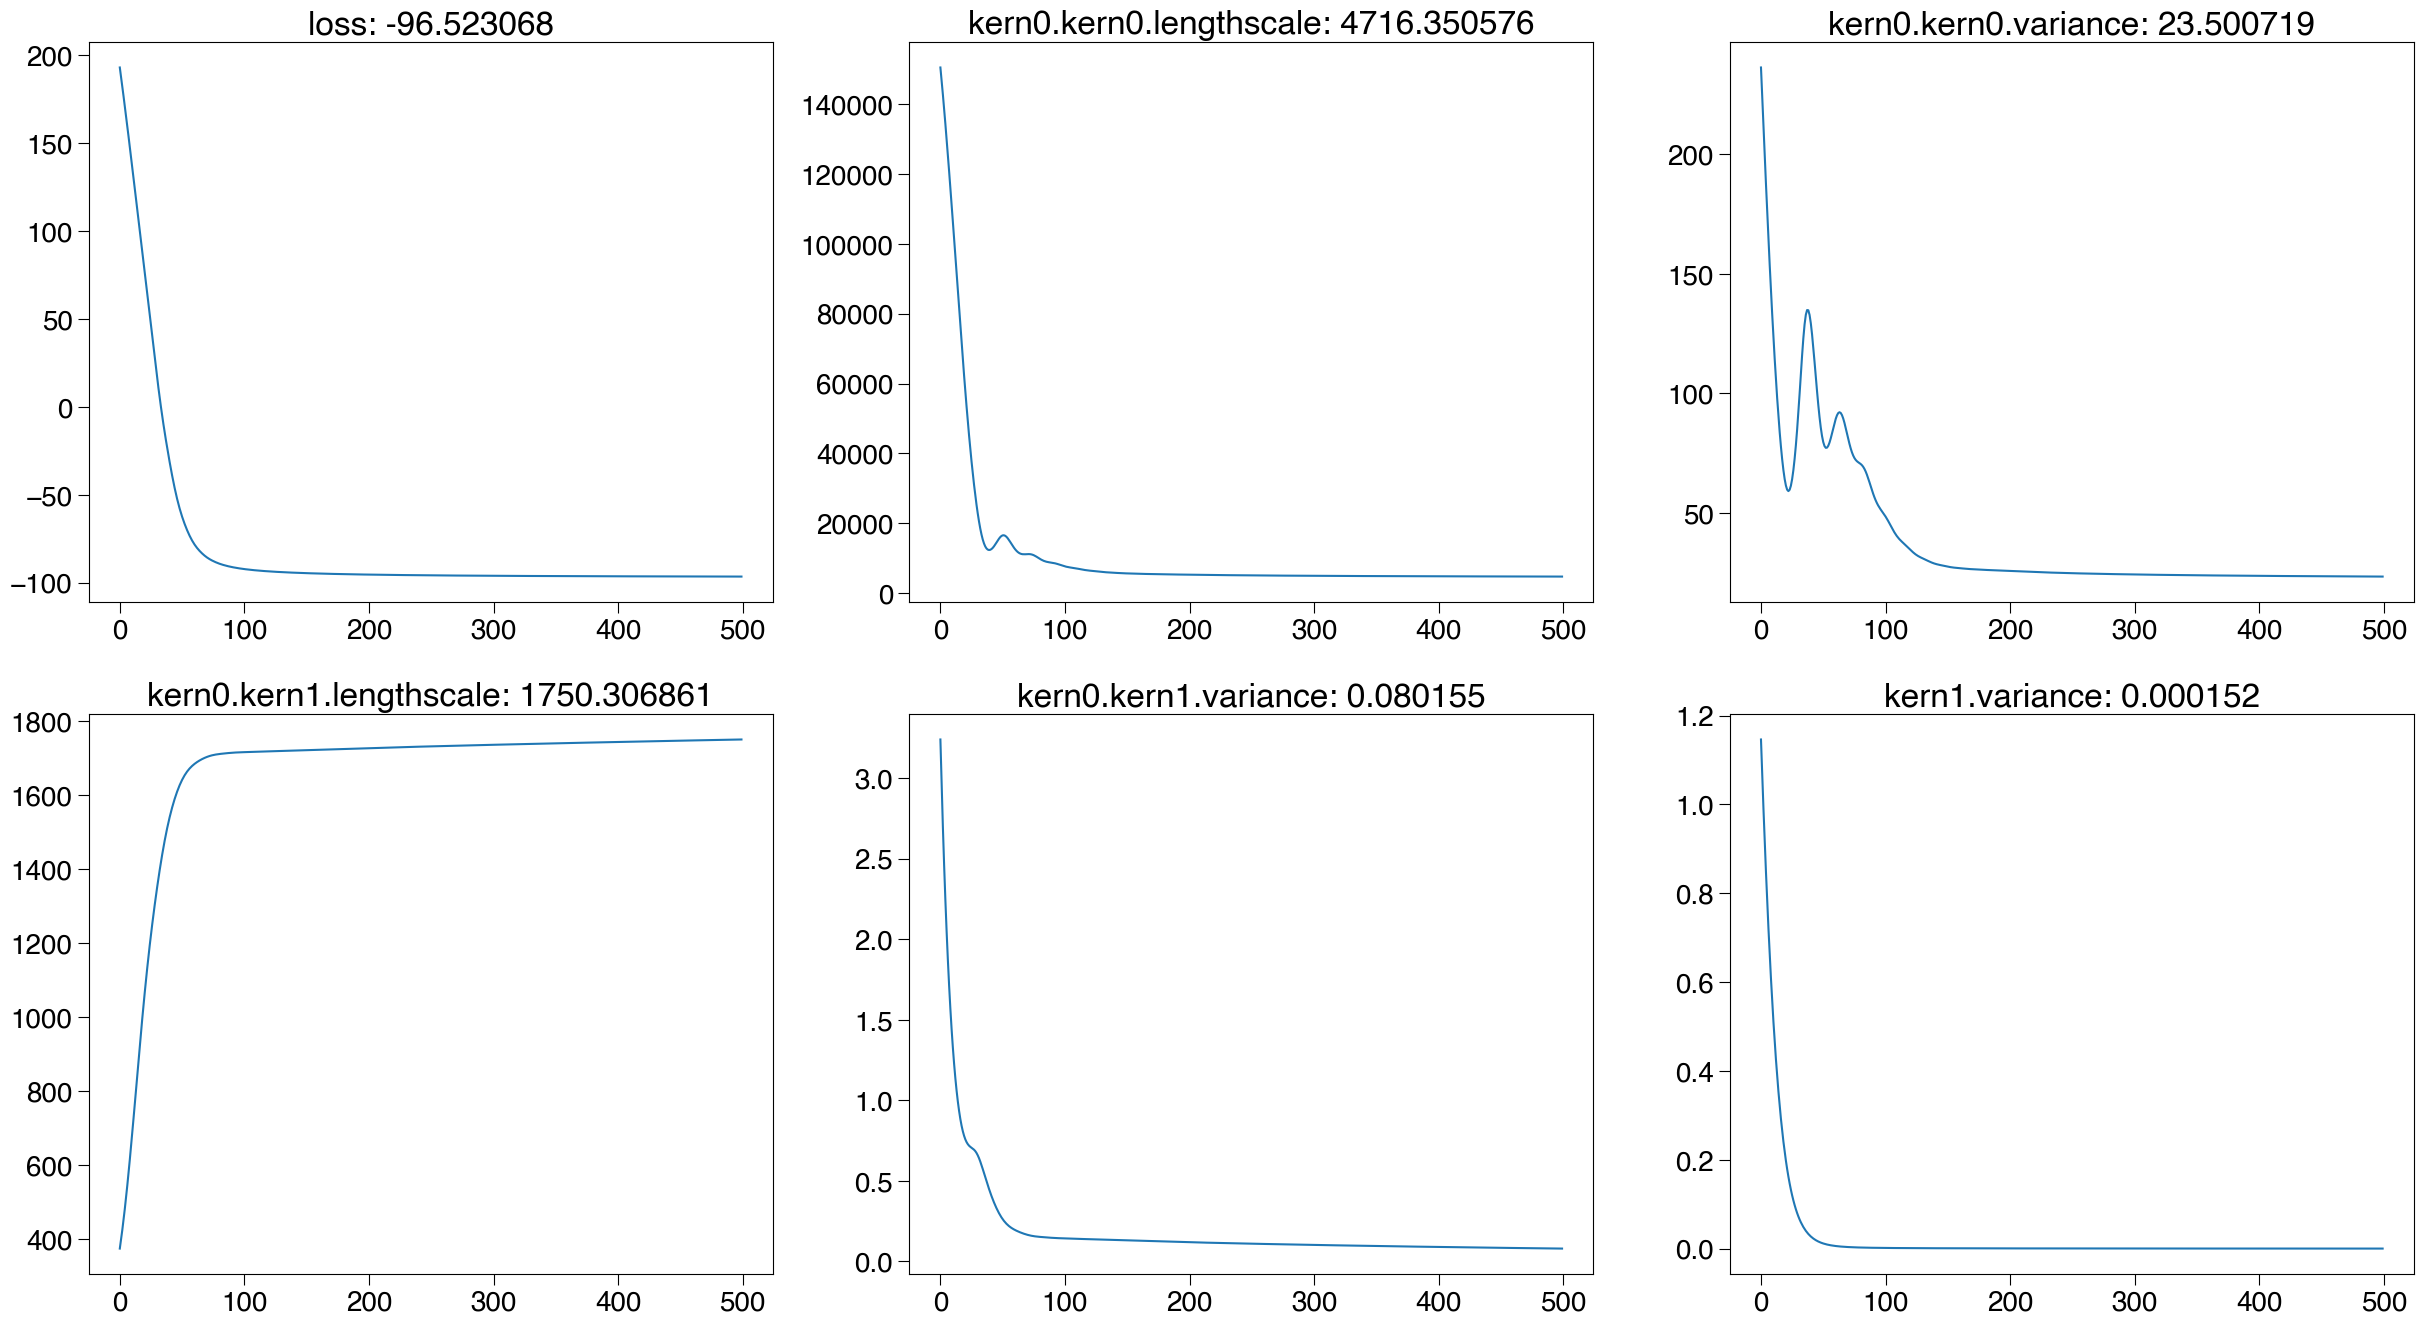

In [4]:
# calculate computational time
import pyro.contrib.gp as gp

st = time.time() 

pyro.clear_param_store()


#generate kernels
Matern32_kernel = PSTHM.kernels.Matern32(
    input_dim=1,variance=torch.tensor(60**2),lengthscale=torch.tensor(12000))
Matern32_kernel.set_prior("variance", dist.Uniform(torch.tensor(1.), torch.tensor(500.)))
Matern32_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(2000.), torch.tensor(200000.)))

Matern32_kernel2 = PSTHM.kernels.Matern32(
    input_dim=1)
Matern32_kernel2.set_prior("variance", dist.Uniform(torch.tensor(0.01), torch.tensor(40.)))
Matern32_kernel2.set_prior("lengthscale", dist.Uniform(torch.tensor(100.), torch.tensor(2000.)))

Whitenoise_kernel = PSTHM.kernels.WhiteNoise(
    input_dim=1, variance=torch.tensor(1))
Whitenoise_kernel.set_prior('variance', dist.Uniform(torch.tensor(1e-3**2), torch.tensor(2**2)))

combined_kernel = PSTHM.kernels.Sum(Matern32_kernel, Matern32_kernel2)
combined_kernel = PSTHM.kernels.Sum(combined_kernel, Whitenoise_kernel)

gpr = PSTHM.model.GPRegression_V(X, y, combined_kernel,noise=torch.tensor(y_sigma**2),jitter=1e-5)

#Empirical bayes optimization for noisy-input GP, we need to provide x_sigma here
gpr,track_list = PSTHM.opti.SVI_NI_optm(gpr,x_sigma,num_iteration=500)

#calulate log likelihood of the model prediction
pred_y,_ = gpr(X.double(), full_cov=True)

fit_likelihood = PSTHM.post.cal_likelihood(y.detach().numpy(),y_sigma.detach().numpy(),pred_y.detach().numpy())
print('Likelihood {:3.3f}'.format(fit_likelihood))
axes = PSTHM.plotting.plot_track_list(track_list)

et = time.time() # get the end time

# get the execution time
elapsed_time = et - st
print('Execution time: {:3.3f} s'.format( elapsed_time))

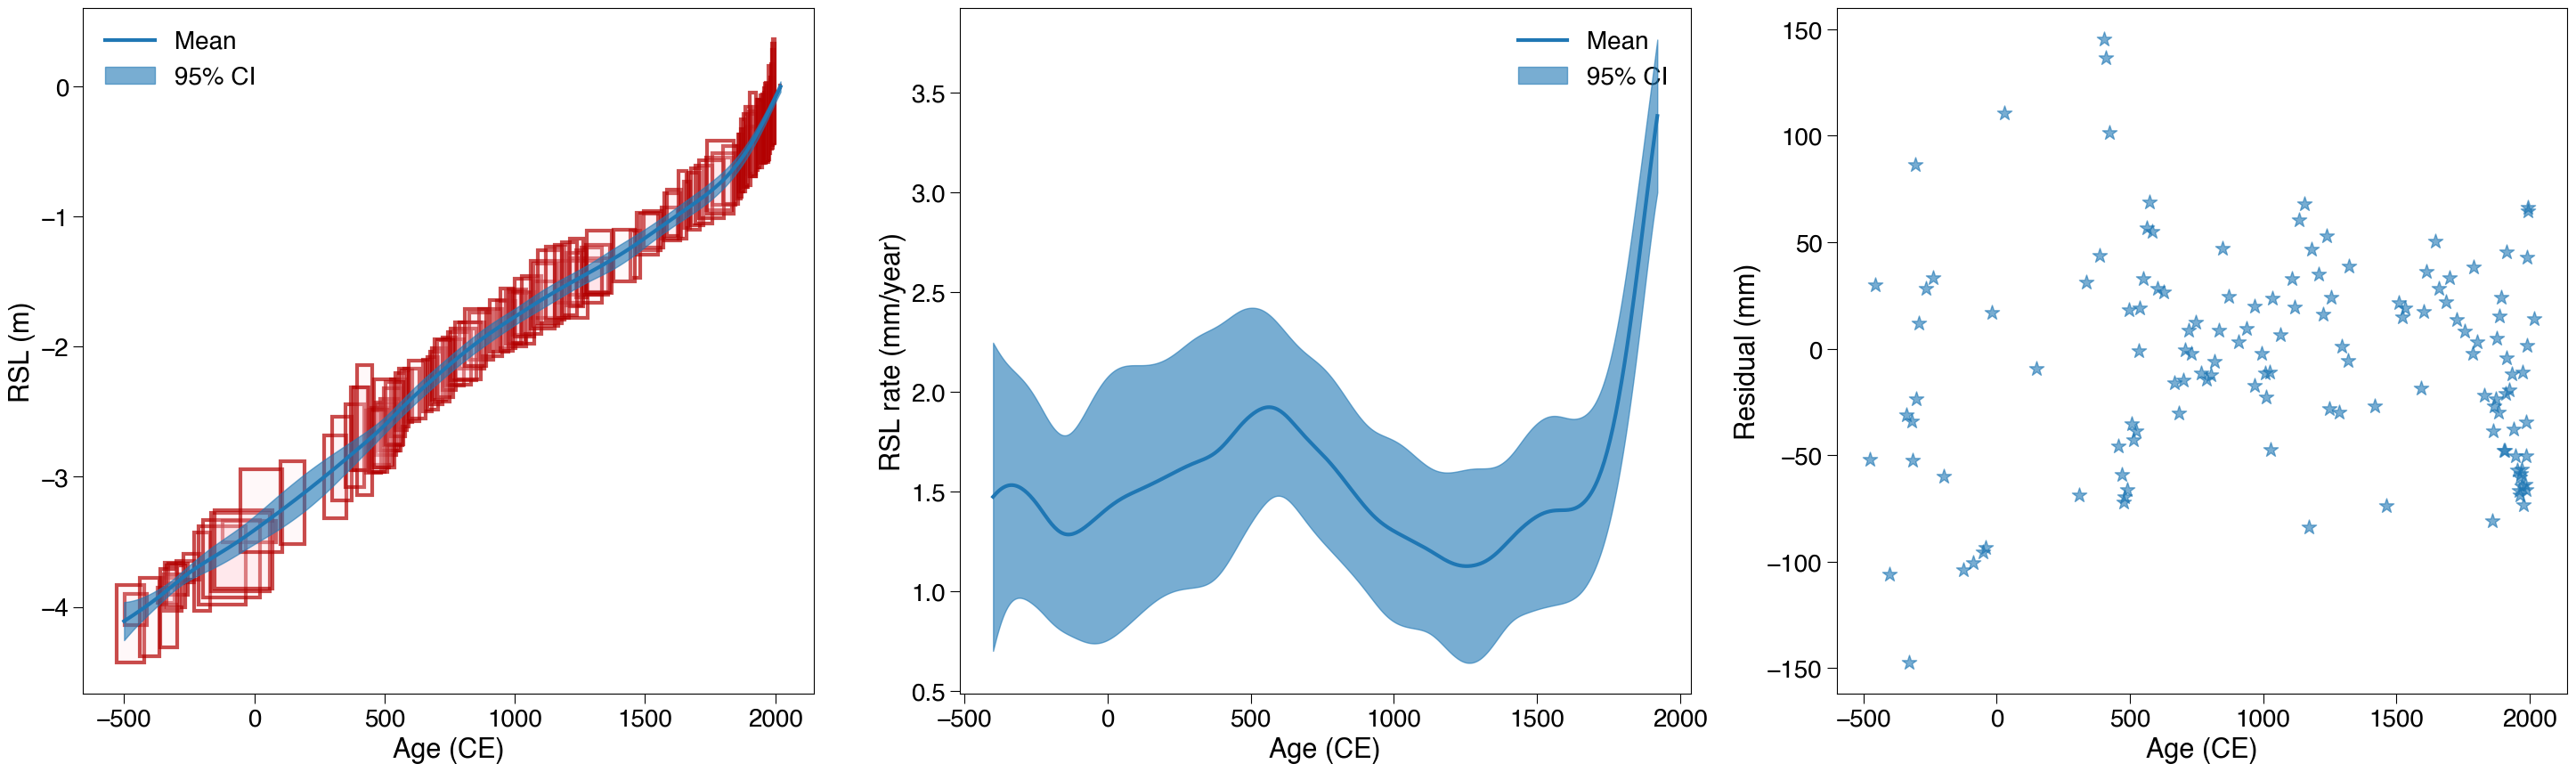

In [6]:
# Make predictions on new inputs
x_test = torch.arange(-500,2025,5.,requires_grad=True).double()
c_kernel_y_mean, c_kernel_y_var = gpr(x_test, full_cov=True)
c_kernel_sd = torch.diag(c_kernel_y_var).sqrt()  # standard deviation at each input point x
rsl_time,c_kernel_rsl_rate,c_kernel_rsl_rate_sd = PSTHM.post.cal_rate_var(x_test.detach().numpy(),c_kernel_y_var.detach().numpy(),c_kernel_y_mean.detach().numpy())

axes = PSTHM.plotting.plot_tem_regression(X,y,x_sigma,y_sigma,x_test,c_kernel_y_mean,c_kernel_sd,
                          rsl_time,c_kernel_rsl_rate,c_kernel_rsl_rate_sd)

Let's compare our results with results by Ashe et al., 2019:

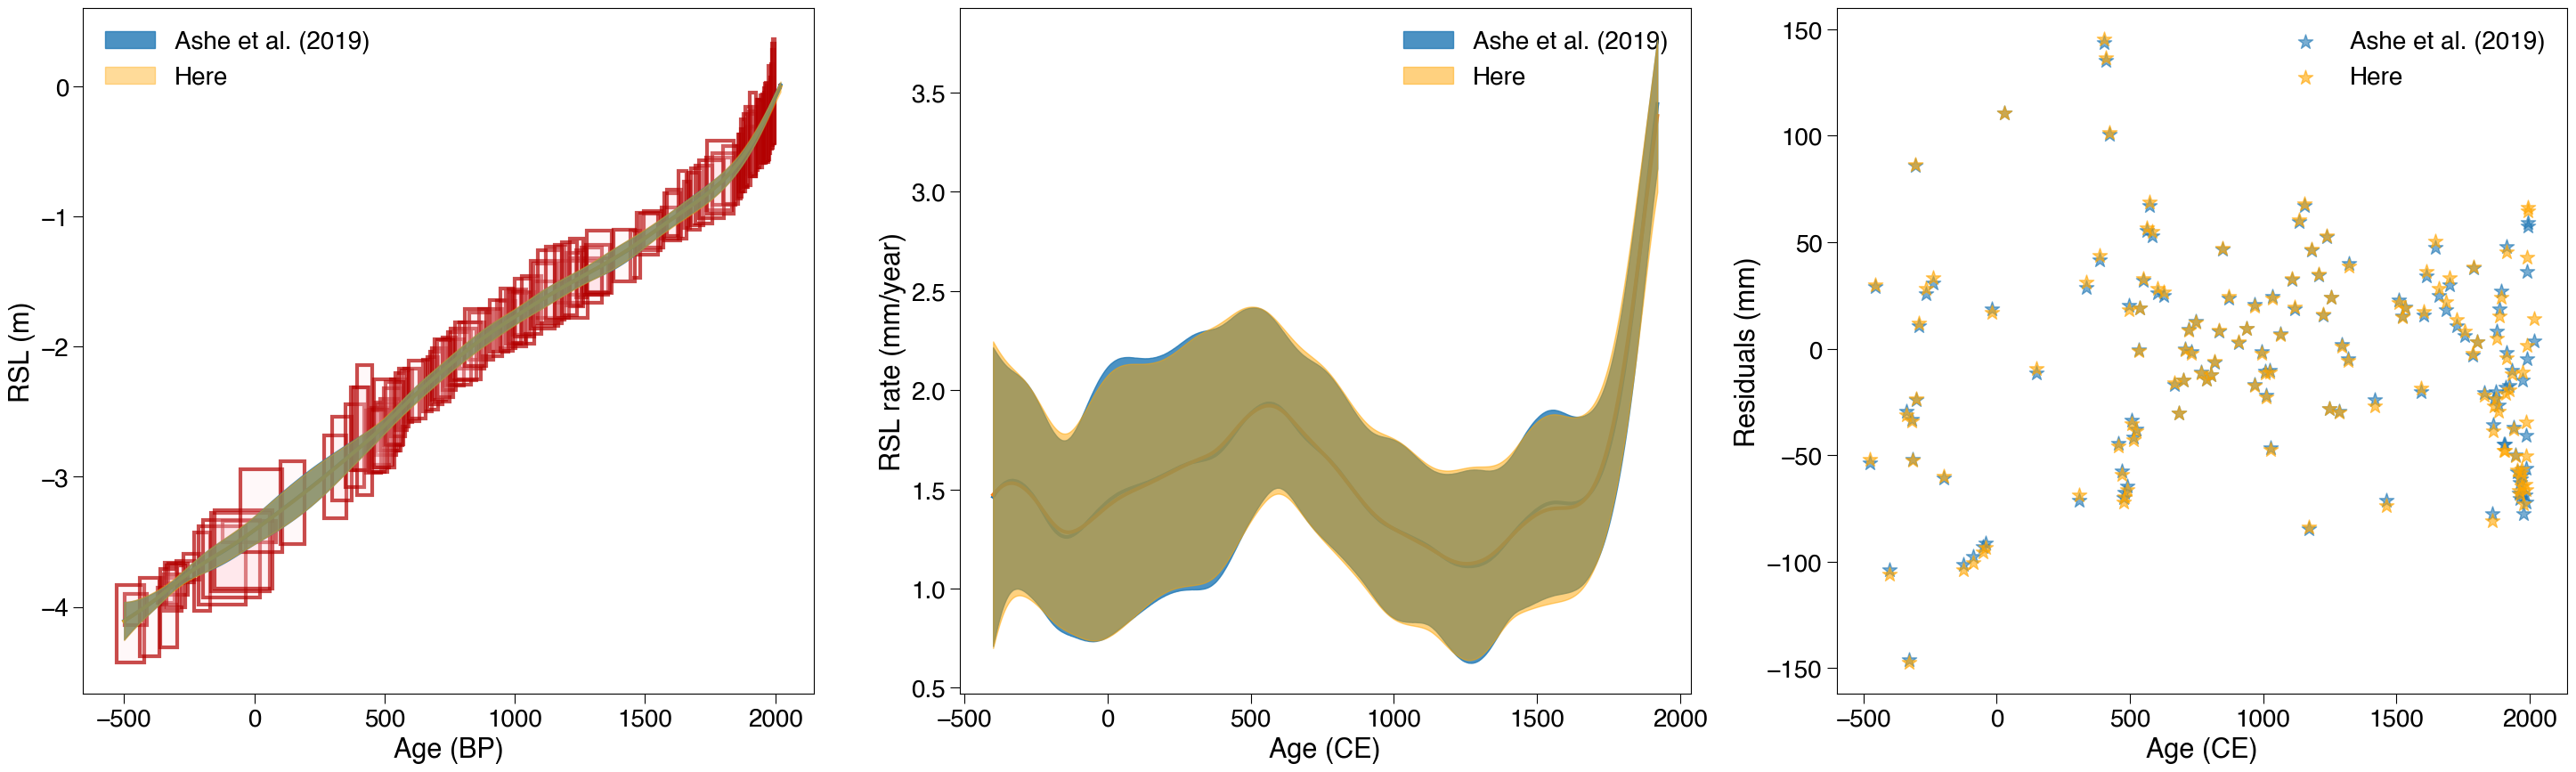

In [7]:
#-----plotting---------
fig= plt.figure(figsize=(36, 10))
ax = plt.subplot(131)
PSTHM.plotting.plot_uncertainty_boxes(X,y, x_sigma*2,y_sigma*2,ax=ax)

plt.plot(ashe_rsl_time,ashe_mean_rsl,linewidth=3)
plt.plot(x_test.detach().numpy(),c_kernel_y_mean.detach().numpy(),linewidth=3,color='orange',alpha=0.8)

plt.fill_between(
            ashe_rsl_time,  # plot the two-sigma uncertainty about the mean
            (ashe_mean_rsl - 2.0 * ashe_sd),
            (ashe_mean_rsl + 2.0 * ashe_sd),
            color="C0",
            alpha=0.8,zorder=10,label='Ashe et al. (2019)')
ax.fill_between(
            x_test.detach().numpy(),  # plot the two-sigma uncertainty about the mean
            (c_kernel_y_mean - 2.0 * c_kernel_sd).detach().numpy(),
            (c_kernel_y_mean + 2.0 * c_kernel_sd).detach().numpy(),
            color="orange",
            alpha=0.4,zorder=10,label='Here')
plt.legend()
ax = plt.subplot(132)
ax.plot(rsl_rate_time,ashe_rsl_rate*1000,linewidth=3)
ax.fill_between(
            rsl_rate_time,  # plot the two-sigma uncertainty about the mean
            (ashe_rsl_rate - 2.0 * ashe_rsl_rate_sd)*1000,
            (ashe_rsl_rate + 2.0 * ashe_rsl_rate_sd)*1000,
            color="C0",
            alpha=0.8,zorder=10,label='Ashe et al. (2019)')

plt.plot(rsl_time,c_kernel_rsl_rate*1000,linewidth=3)
ax.fill_between(
            rsl_time,  # plot the two-sigma uncertainty about the mean
            (c_kernel_rsl_rate - 2.0 * c_kernel_rsl_rate_sd)*1000,
            (c_kernel_rsl_rate + 2.0 * c_kernel_rsl_rate_sd)*1000,
            color="orange",
            alpha=0.5,zorder=10,label='Here')

plt.xlabel('Age (CE)')
plt.ylabel('RSL rate (mm/year)')
plt.legend()

ax = plt.subplot(133)
f_ashe = interpolate.interp1d(ashe_rsl_time,ashe_mean_rsl)
plt.scatter(X,(y-f_ashe(X))*1000,s=150,marker='*',color='C0',alpha=0.6,label='Ashe et al. (2019)')
plt.scatter(X,(y-pred_y.detach().numpy())*1000,s=150,marker='*',color='orange',alpha=0.6,label='Here')
plt.xlabel('Age (CE)')
plt.ylabel('Residuals (mm)')
plt.legend();

Not bad, we can see our results are pretty much the same as the peer-reviewed published results. And to further prove it, we will do the same thing for Northern North Carolina sea-level records from [Kemp et al., 2011](https://www.pnas.org/doi/abs/10.1073/pnas.1015619108). 

### 2. Northern North Carolina

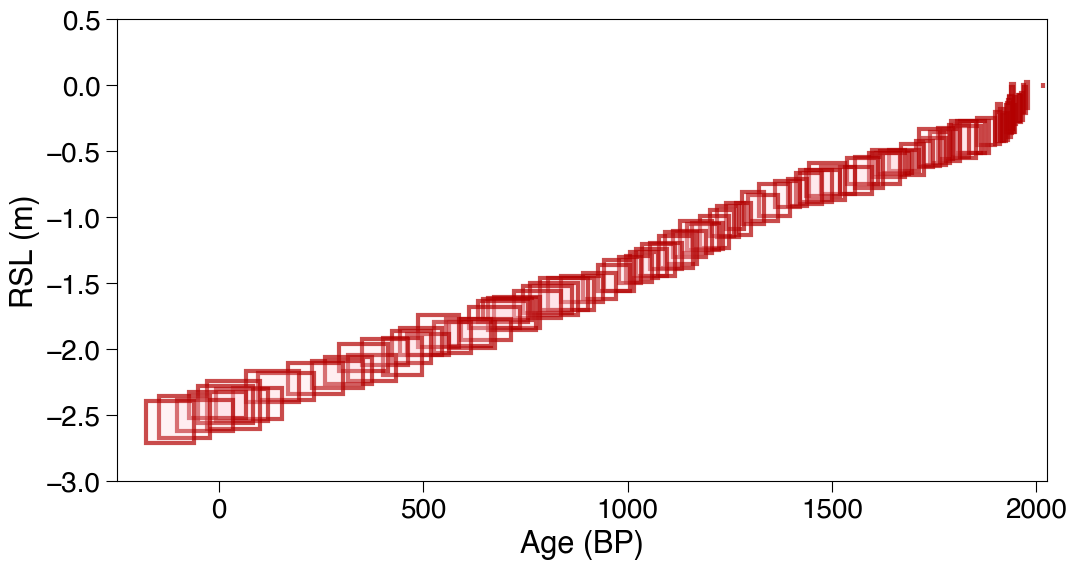

In [8]:
#load data 
NNC_X,NNC_y,NNC_y_sigma,NNC_x_sigma,NNC_lon,NNC_lat = PSTHM.load.load_local_rsl_data('../../Data/NNC_CC.csv')

#visualize data
ax = PSTHM.plotting.plot_uncertainty_boxes(NNC_X,NNC_y, NNC_x_sigma*2,NNC_y_sigma*2)
ax.set_xlim(-250,2025)
ax.set_ylim(-3,0.5)
plt.show();

  0%|          | 0/500 [00:00<?, ?it/s]

Likelihood 208.366
Execution time: 2.763 s


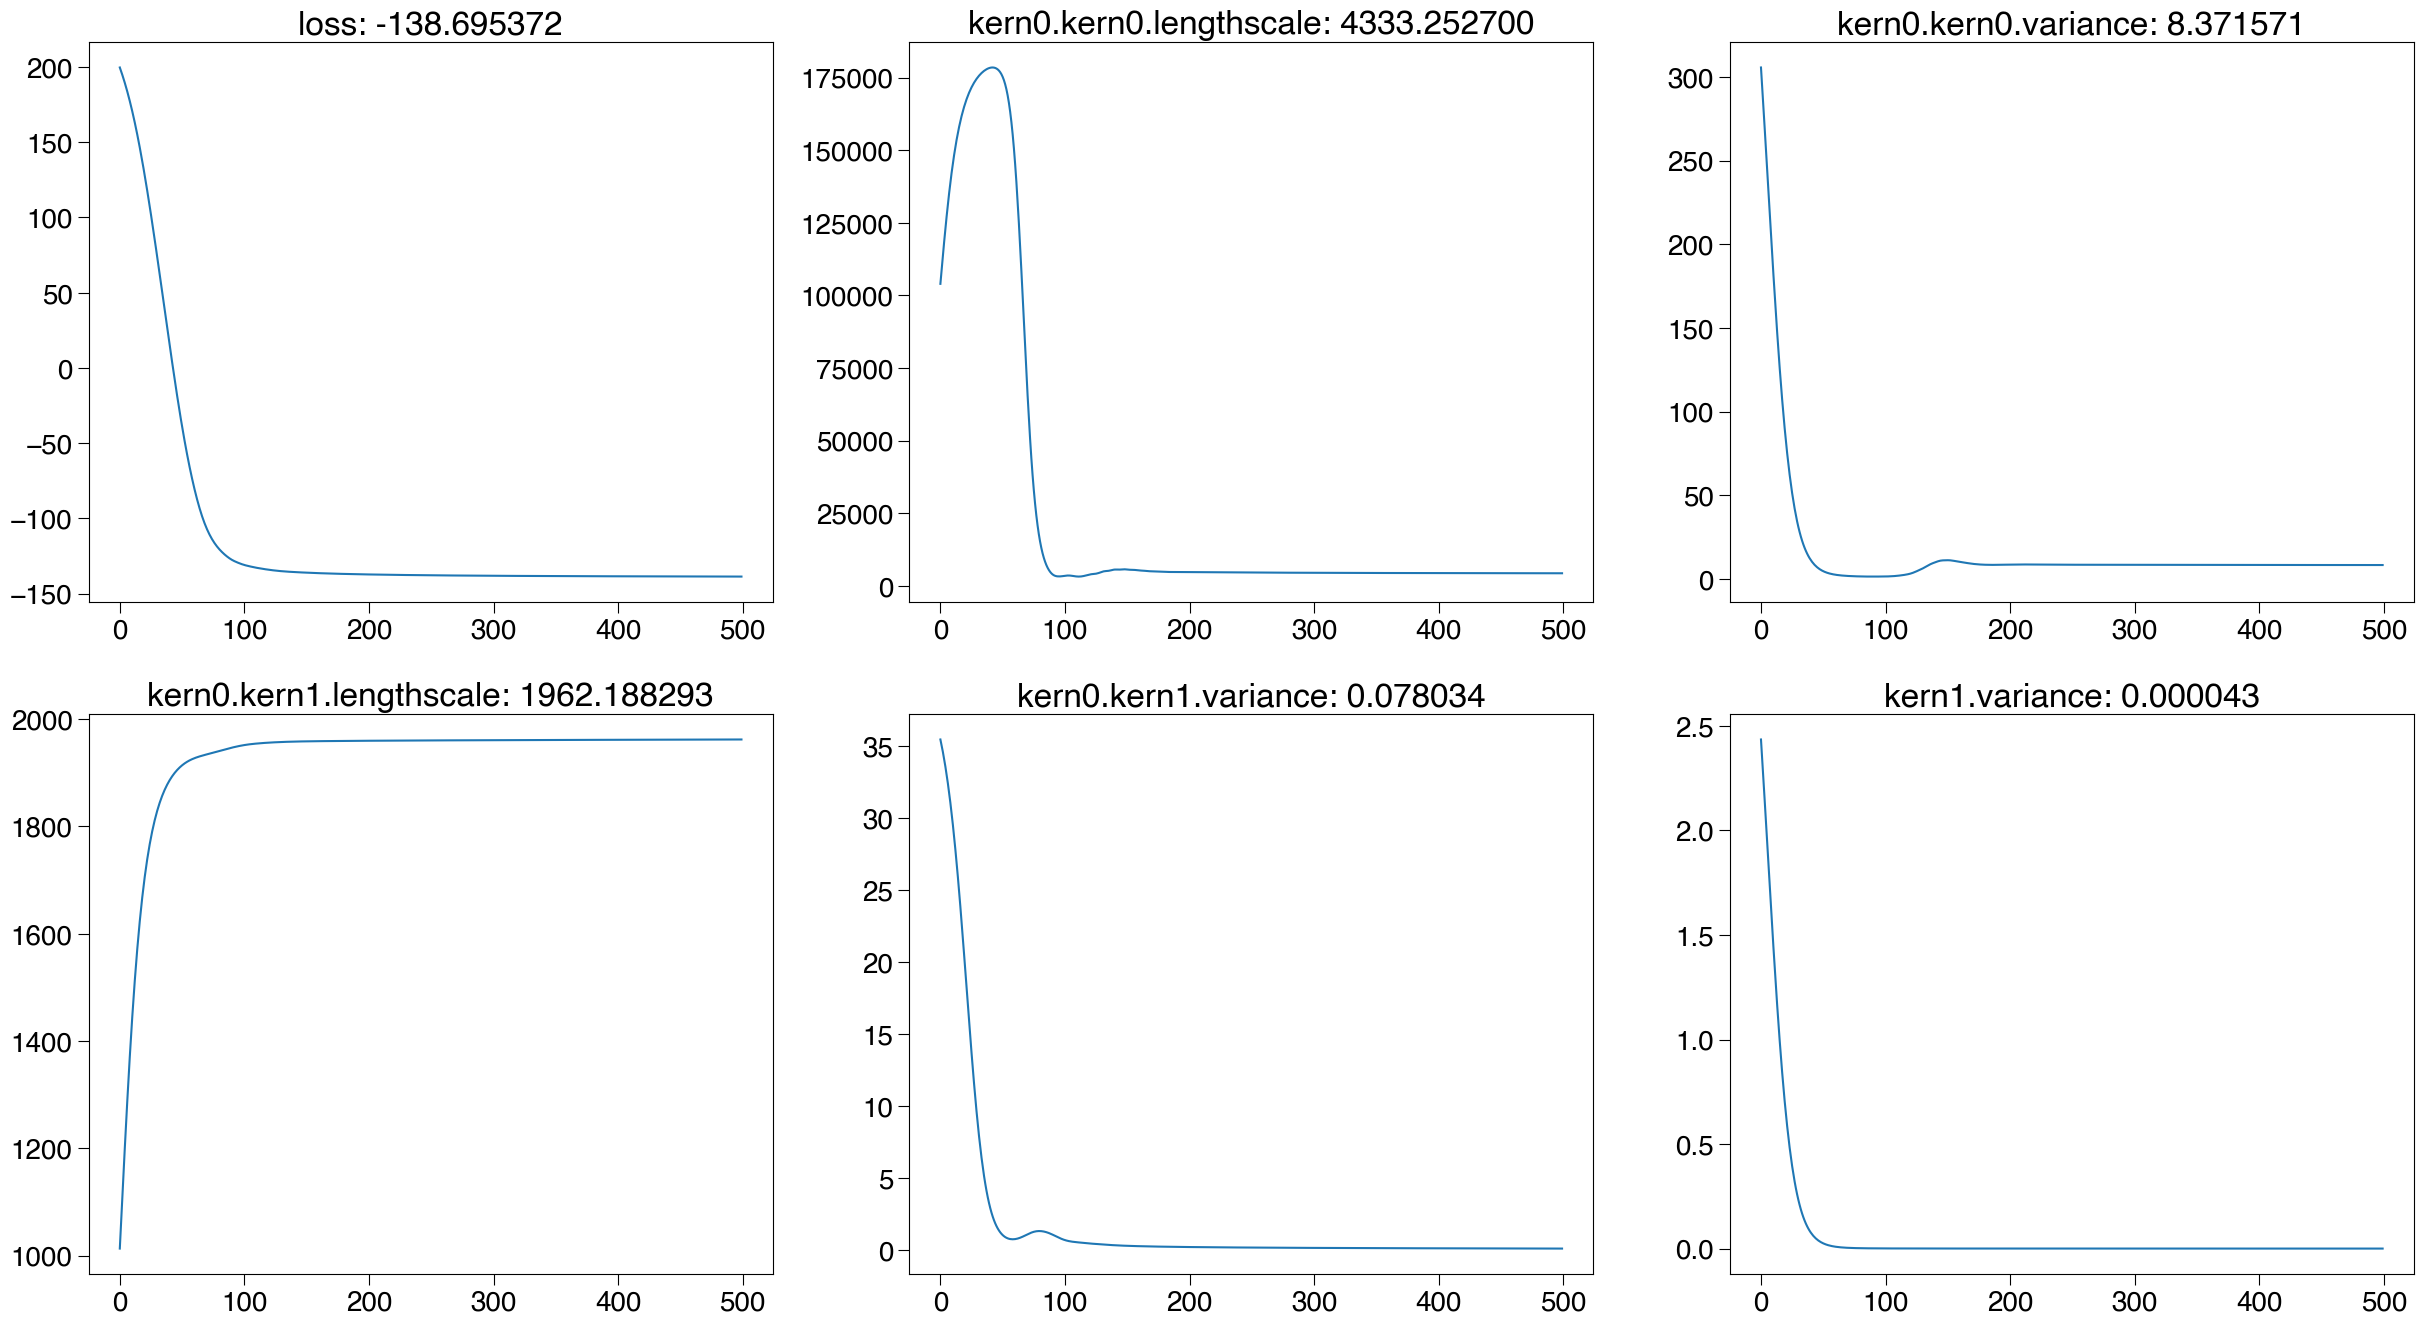

In [9]:
# calculate computational time
st = time.time() 

pyro.clear_param_store()

#generate kernels 
Matern32_kernel = PSTHM.kernels.Matern32(
    input_dim=1,variance=torch.tensor(60**2),lengthscale=torch.tensor(12000))
Matern32_kernel.set_prior("variance", dist.Uniform(torch.tensor(1.), torch.tensor(500.)))
Matern32_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(2000.), torch.tensor(200000.)))

Matern32_kernel2 = PSTHM.kernels.Matern32(
    input_dim=1)
Matern32_kernel2.set_prior("variance", dist.Uniform(torch.tensor(0.01), torch.tensor(40.)))
Matern32_kernel2.set_prior("lengthscale", dist.Uniform(torch.tensor(100.), torch.tensor(2000.)))

Whitenoise_kernel = PSTHM.kernels.WhiteNoise(
    input_dim=1, variance=torch.tensor(1))
Whitenoise_kernel.set_prior('variance', dist.Uniform(torch.tensor(1e-3**2), torch.tensor(2**2)))

combined_kernel = PSTHM.kernels.Sum(Matern32_kernel, Matern32_kernel2)
combined_kernel = PSTHM.kernels.Sum(combined_kernel, Whitenoise_kernel)

gpr = PSTHM.model.GPRegression_V(NNC_X, NNC_y, combined_kernel,noise=torch.tensor(NNC_y_sigma**2),jitter=1e-5)

#Empirical bayes optimization, default iteration is 1000
gpr,track_list = PSTHM.opti.SVI_NI_optm(gpr,NNC_x_sigma,num_iteration=500)

#calulate log likelihood of the model prediction
pred_y,_ = gpr(NNC_X.double(), full_cov=True)

fit_likelihood = PSTHM.post.cal_likelihood(NNC_y.detach().numpy(),NNC_y_sigma.detach().numpy(),pred_y.detach().numpy())
print('Likelihood {:3.3f}'.format(fit_likelihood))
axes = PSTHM.plotting.plot_track_list(track_list)

et = time.time() # get the end time

# get the execution time
elapsed_time = et - st
print('Execution time: {:3.3f} s'.format( elapsed_time))

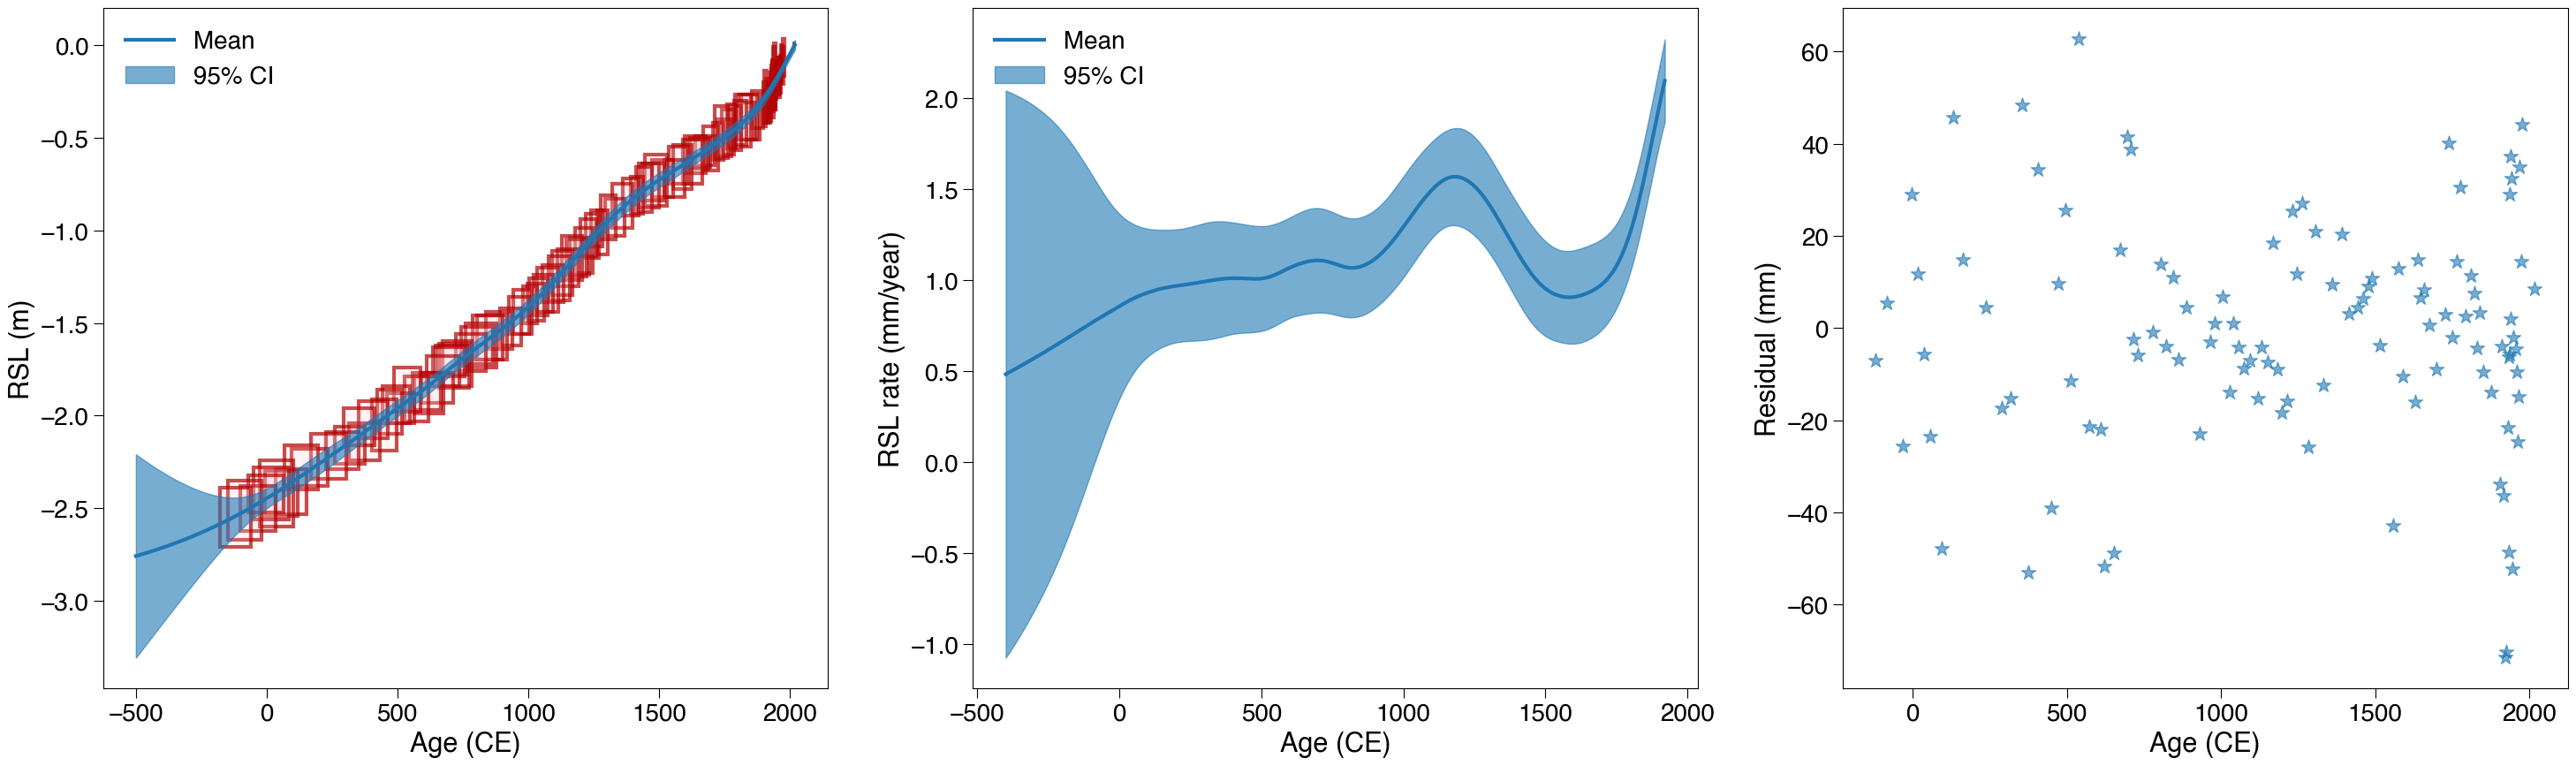

In [10]:
# Make predictions on new inputs
x_test = torch.arange(-500,2025,5.,requires_grad=True)
c_kernel_y_mean, c_kernel_y_var = gpr(x_test.double(), full_cov=True)
c_kernel_sd = torch.diag(c_kernel_y_var).sqrt()  # standard deviation at each input point x
rsl_time,c_kernel_rsl_rate,c_kernel_rsl_rate_sd = PSTHM.post.cal_rate_var(x_test.detach().numpy(),c_kernel_y_var.detach().numpy(),c_kernel_y_mean.detach().numpy())

axes = PSTHM.plotting.plot_tem_regression(NNC_X,NNC_y,NNC_x_sigma,NNC_y_sigma,x_test,c_kernel_y_mean,c_kernel_sd,
                          rsl_time,c_kernel_rsl_rate,c_kernel_rsl_rate_sd)

Again, let's compare it with results from Ashe et al., 2019.

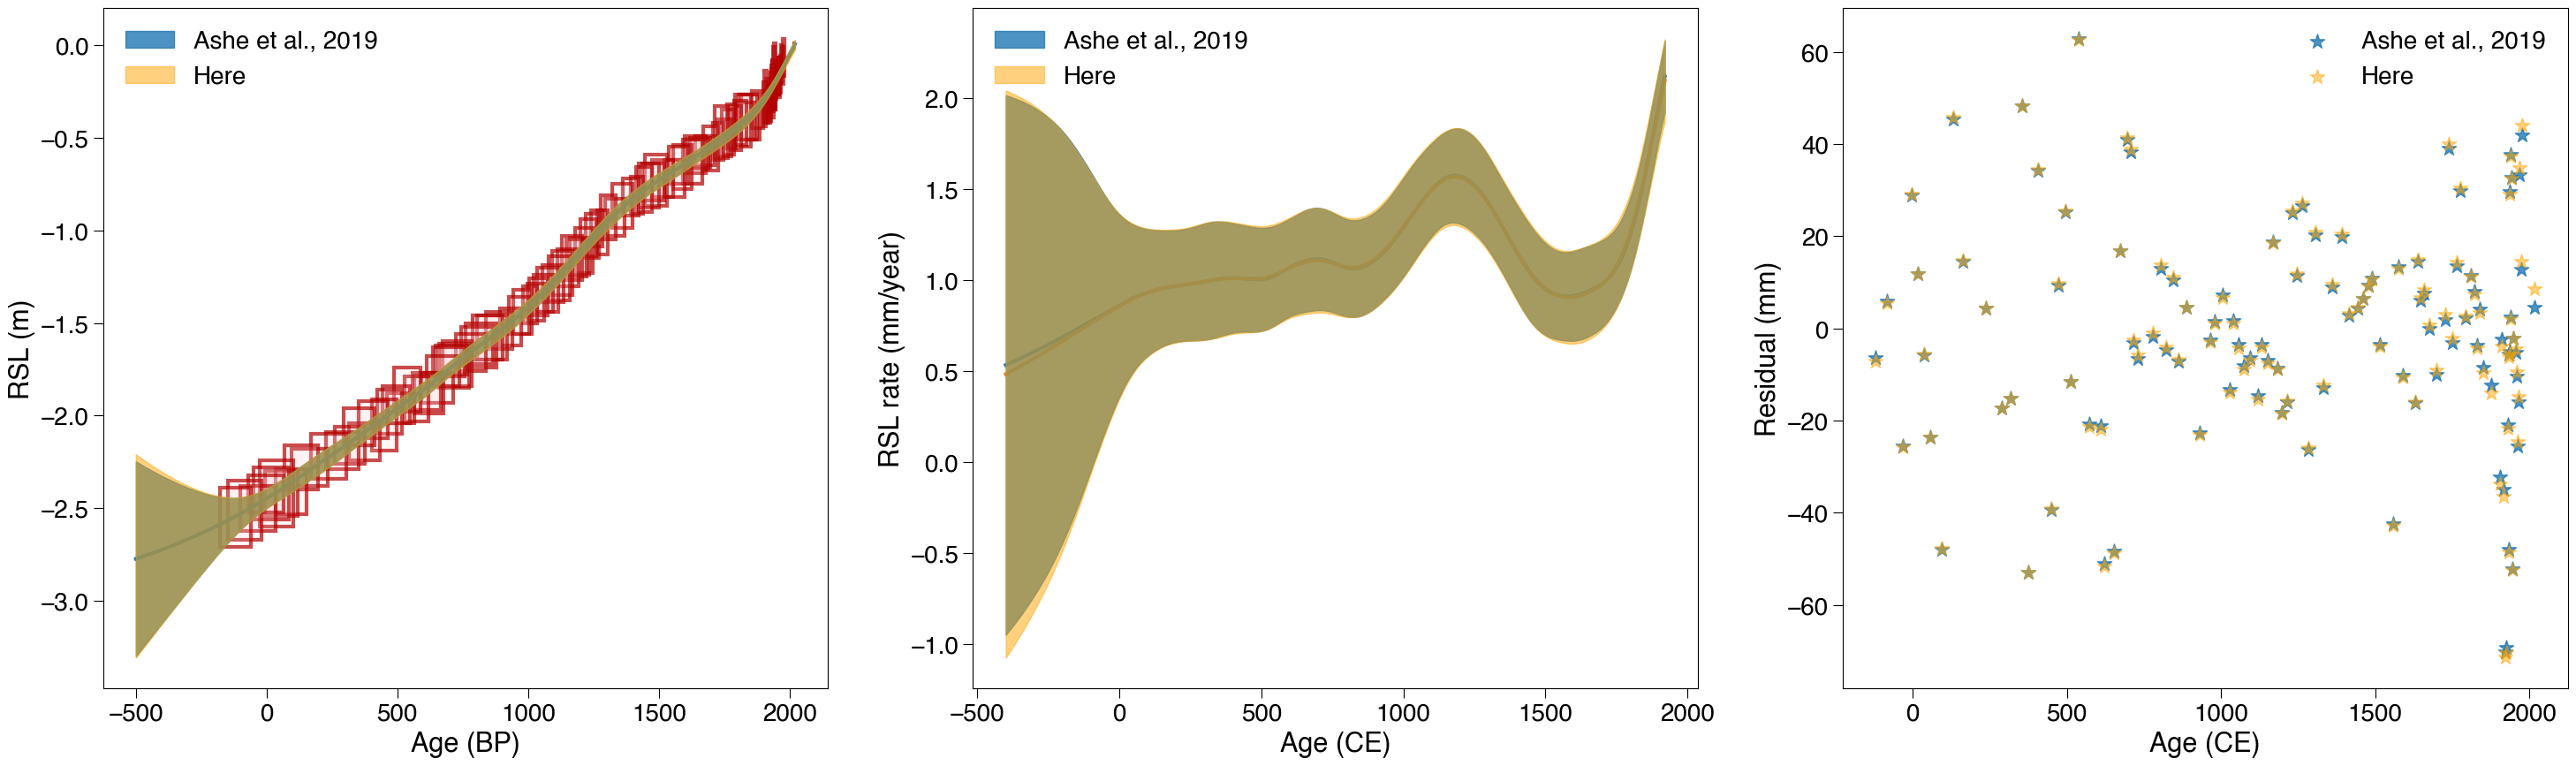

In [11]:
#compare it with the result from the original paper from Ashe et al., 2019
ashe_NNC_mean_rsl =np.array(pd.read_csv('../../Data/ashe_NNC_mean.csv',header=None))[:,0] /1000 #convert mm to m
NNC_cov_matrix = np.array(pd.read_csv('../../Data/ashe_NNC_cov.csv',header=None)) 
NNC_ashe_sd = np.sqrt(np.diag(NNC_cov_matrix))/1000
NNC_rsl_time = np.arange(-500,2025,5.)
rsl_rate_time,NNC_ashe_rsl_rate,NNC_ashe_rsl_rate_sd = PSTHM.post.cal_rate_var(NNC_rsl_time,NNC_cov_matrix,ashe_NNC_mean_rsl)
NNC_ashe_rsl_rate_sd/=1000 #convert mm to m

#-----plotting---------
fig= plt.figure(figsize=(36, 10))
ax = plt.subplot(131)
ax = PSTHM.plotting.plot_uncertainty_boxes(NNC_X,NNC_y, NNC_x_sigma*2,NNC_y_sigma*2,ax=ax)

plt.plot(NNC_rsl_time,ashe_NNC_mean_rsl,linewidth=3)
plt.fill_between(
            NNC_rsl_time,  # plot the two-sigma uncertainty about the mean
            (ashe_NNC_mean_rsl - 2.0 * NNC_ashe_sd),
            (ashe_NNC_mean_rsl + 2.0 * NNC_ashe_sd),
            color="C0",
            alpha=0.8,zorder=10,label='Ashe et al., 2019')

ax.fill_between(
            x_test.detach().numpy(),  # plot the two-sigma uncertainty about the mean
            (c_kernel_y_mean - 2.0 * c_kernel_sd).detach().numpy(),
            (c_kernel_y_mean + 2.0 * c_kernel_sd).detach().numpy(),
            color="orange",
            alpha=0.5,zorder=10,label='Here')
plt.legend()

ax = plt.subplot(132)
ax.plot(rsl_rate_time,NNC_ashe_rsl_rate*1000,linewidth=3)
plt.plot(rsl_time,c_kernel_rsl_rate*1000,linewidth=3)

ax.fill_between(
            rsl_rate_time,  # plot the two-sigma uncertainty about the mean
            (NNC_ashe_rsl_rate - 2.0 * NNC_ashe_rsl_rate_sd)*1000,
            (NNC_ashe_rsl_rate + 2.0 * NNC_ashe_rsl_rate_sd)*1000,
            color="C0",
            alpha=0.8,zorder=10,label='Ashe et al., 2019')
ax.fill_between(
            rsl_time,  # plot the two-sigma uncertainty about the mean
            (c_kernel_rsl_rate - 2.0 * c_kernel_rsl_rate_sd)*1000,
            (c_kernel_rsl_rate + 2.0 * c_kernel_rsl_rate_sd)*1000,
            color="orange",
            alpha=0.5,zorder=10,label='Here')

plt.xlabel('Age (CE)')
plt.ylabel('RSL rate (mm/year)')
plt.legend()

ax = plt.subplot(133)
f_NNC_ashe = interpolate.interp1d(NNC_rsl_time,ashe_NNC_mean_rsl)
plt.scatter(NNC_X,(NNC_y-f_NNC_ashe(NNC_X))*1000,s=150,marker='*',color='C0',alpha=0.8,label='Ashe et al., 2019')
plt.scatter(NNC_X,(NNC_y-pred_y.detach().numpy())*1000,s=150,marker='*',color='orange',label='Here',alpha=0.5)

plt.xlabel('Age (CE)')
plt.ylabel('Residual (mm)')
plt.legend();

Great, we have now successfully replicate two sea-level reconstruction results by Ashe et al., 2019, hooray! You can now start to do GP regression based on your own data and self-defined GP kernels!

This is the end of temporal GP tutorial series. And other than just using temporal correlation, we can also use spatial correlation to inform us about paleo-environmental change. If it is something interested to you, we will see you in next tutorial series about sptio-temporal GP.

Thanks for going through this tutorial, we are actively developing PaleoSTeHM now, so your feedback will be truely valueable to us. You can fill this [survey](https://docs.google.com/forms/d/e/1FAIpQLSepqtT81tw_tA90RnVJ0WxBx-j4K0NMGZpc3gXwrwoXylm_EQ/viewform) to let us know what do you think about this tutorial, which will shape the future direction of PaleoSTeHM.

### Try you own data!


In [11]:
#Try it here!